# 多値分類(4変数ver)

In [2]:
import numpy as np          # 数値計算ライブラリ
import matplotlib.pyplot as plt    # グラフ描画ライブラリ
import torch                 # 機械学習ライブラリPyTorch
from torch import nn        # PyTorchのニューラルネットワークモジュール
from torchviz import make_dot      # PyTorchのグラフ可視化ツール
import japanize_matplotlib  # matplotlibの日本語表示を可能にするライブラリ
import torch.optim as optim # PyTorchの最適化アルゴリズムを定義するoptimモジュール
import pandas as pd         # データフレーム処理のためのライブラリ
import sklearn              # 機械学習ライブラリscikit-learn
from torchinfo import summary   # モデルのサマリー情報を表示するためのライブラリ
from sklearn.model_selection import train_test_split  # データのトレーニングとテストの分割を行う関数
from sklearn.metrics import accuracy_score   # 正解率を計算するための関数


# 以下可視性のために定義。
import inspect # フレームを取得するためのライブラリ
from IPython.display import display # データフレームを表示するためのライブラリ

# 引数の変数名を出力する変数。ただし仕様上、関数を呼び出した場所と同スコープの変数なら1。その一個上なら2，さらにひとつ上なら3にしなければならない。
def print_var_name(var,n=1):
    # 現在のフレームを取得する
    current_frame = inspect.currentframe()
    # 現在のフレームのn回外側のフレームを取得する
    outer_frame = current_frame
    for _ in range(n):
        outer_frame =outer_frame.f_back
    # 外側のフレームのローカル変数を取得する。2次元タプル?がずらっと配列で並んでいる。
    locals_dict = outer_frame.f_locals
    # 変数名を取得する
    var_name = [k for k, v in locals_dict.items() if v is var]
    if not var_name:
        print("変数が見つかりませんでした。")
    else:
        # 変数名を出力する
        print("変数名 : ",var_name[0]," 変数型は ",type(var))

def dataframe_converter(func):
    def wrapper(*args, **kwargs):
        for arg in args:
            
            try:
                print("形状は",arg.shape)
            except:
                pass

            try:
                # 引数がNumPy配列の場合はPandasデータフレームに変換する
                print_var_name(arg,2)
                if isinstance(arg, np.ndarray):
                    df = pd.DataFrame(arg)
                    # デコレータで修飾された関数にデータフレームを渡す
                    func(df)
                elif isinstance(arg, torch.Tensor):
                    df = pd.DataFrame(arg.detach().numpy())
                    # デコレータで修飾された関数にデータフレームを渡す
                    func(df)
                elif isinstance(arg, sklearn.utils.Bunch):
                    df = pd.DataFrame(arg.data, columns=arg.feature_names)
                    # デコレータで修飾された関数にデータフレームを渡す
                    func(df)
                else:
                    # デコレータで修飾された関数にそのままのオブジェクトを渡す
                    func(arg)
            except:
                # デコレータで修飾された関数にそのままのオブジェクトを渡す
                func(arg)
    return wrapper

@dataframe_converter
def display_custom(obj,head=True): # 引数のオブジェクトを表示する。可視性を高めるためにpdに変更するがおそらく大規模の場合は乱用はパフォーマンスに影響する。
    # 引数のオブジェクトを表示する
    if head and isinstance(obj, pd.DataFrame):
        display(obj.head())
        
    else:
        display(obj)

In [3]:
#変数名はできる限り短いプレフィックスを使用する。
#np_をnumpy配列、df_をデータフレーム、t_をテンソル、b_をsklearn.utils.Bunchとする。

In [9]:
# データの読み込み、前処理
from sklearn.datasets import load_iris
b_iris = load_iris()
np_iris_params_data = b_iris.data
np_iris_labels = b_iris.target

In [11]:
# データの分割
np_iris_params_train, np_iris_params_test, np_iris_labels_train, np_iris_labels_test = train_test_split(np_iris_params_data, np_iris_labels, test_size=0.5, random_state=0)

In [12]:
# テンソルに変換
t_iris_params_train = torch.tensor(np_iris_params_train, dtype=torch.float32)
t_iris_params_test = torch.tensor(np_iris_params_test, dtype=torch.float32)
t_iris_labels_train = torch.tensor(np_iris_labels_train, dtype=torch.int64)
t_iris_labels_test = torch.tensor(np_iris_labels_test, dtype=torch.int64)


In [19]:
#  モデルの定義
# - nn.Moduleを継承した独自のネットワーククラスを作成
# - 層の構造や活性化関数などを定義

class Net(nn.Module):
    def __init__(self,n_input,n_output):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_output)
        self.l1.weight.data.fill_(1.0)
        self.l1.bias.data.fill_(1.0)

    def forward(self, x):
        x = self.l1(x)
        return x

# 入力データと次元数
inputs = t_iris_params_train
n_input = inputs.shape[1]

# 正解データ
labels = t_iris_labels_train

# 出力層の次元数=クラス数    
n_output = len(np.unique(labels))

# インスタンス化
net = Net(n_input,n_output)


In [20]:

# 損失関数
criterion = nn.CrossEntropyLoss()

# 最適化関数
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [21]:
# 学習回数
n_epoch = 10000

# 評価結果を格納するリスト(エポック数、訓練データの損失、テストデータの損失、訓練データの正解率、テストデータの正解率)
history = np.zeros((0,5))

In [22]:
# 学習
for epoch in range(n_epoch):
    # 勾配を初期化
    optimizer.zero_grad()
    # 順伝播
    outputs = net(inputs)
    # 損失を計算
    loss = criterion(outputs, labels)
    # 誤差逆伝播
    loss.backward()
    # パラメータ更新
    optimizer.step()
    # 評価
    if epoch % 100 == 0:
        # 訓練データの損失
        train_loss = criterion(net(inputs), labels).item()
        # テストデータの損失
        test_loss = criterion(net(t_iris_params_test), t_iris_labels_test).item()
        # 訓練データの正解率
        train_acc = (net(inputs).argmax(dim=1) == labels).float().mean().item()
        # テストデータの正解率
        test_acc = (net(t_iris_params_test).argmax(dim=1) == t_iris_labels_test).float().mean().item()
        # 評価結果をリストに格納
        history = np.vstack((history, np.array([epoch, train_loss, test_loss, train_acc, test_acc])))
        # 経過を出力
        print("epoch: {}, train_loss: {:.3f}, test_loss: {:.3f}, train_acc: {:.3f}, test_acc: {:.3f}".format(epoch, train_loss, test_loss, train_acc, test_acc))
        

epoch: 0, train_loss: 1.082, test_loss: 1.091, train_acc: 0.347, test_acc: 0.320
epoch: 100, train_loss: 0.651, test_loss: 0.750, train_acc: 0.733, test_acc: 0.600
epoch: 200, train_loss: 0.526, test_loss: 0.633, train_acc: 0.733, test_acc: 0.600
epoch: 300, train_loss: 0.465, test_loss: 0.572, train_acc: 0.760, test_acc: 0.600
epoch: 400, train_loss: 0.426, test_loss: 0.532, train_acc: 0.853, test_acc: 0.667
epoch: 500, train_loss: 0.397, test_loss: 0.502, train_acc: 0.867, test_acc: 0.733
epoch: 600, train_loss: 0.375, test_loss: 0.478, train_acc: 0.880, test_acc: 0.760
epoch: 700, train_loss: 0.356, test_loss: 0.458, train_acc: 0.893, test_acc: 0.813
epoch: 800, train_loss: 0.340, test_loss: 0.441, train_acc: 0.933, test_acc: 0.840
epoch: 900, train_loss: 0.326, test_loss: 0.426, train_acc: 0.933, test_acc: 0.853
epoch: 1000, train_loss: 0.313, test_loss: 0.413, train_acc: 0.933, test_acc: 0.867
epoch: 1100, train_loss: 0.302, test_loss: 0.401, train_acc: 0.947, test_acc: 0.880
epoc

### `net(t_iris_params_test).argmax(dim=1) == t_iris_labels_test).float().mean().item()`の解説

net(inputs) は inputs をモデルに入力した際の出力（予測値）を返します。そして、.argmax(dim=1) は、各入力に対しての予測値の中で最も確率の高いクラスを選択し、そのクラスのインデックスを返します。これにより、各入力に対しての予測ラベルが得られます。

次に、== labels は、各入力に対する予測ラベルと、それぞれの正解ラベル labels を比較し、同じラベルであるかどうかを判定します。この結果は、True/False のテンソルで返されます。

その後、.float() により、True/False のテンソルを1.0/0.0のfloat型のテンソルに変換します。そして、.mean() により、各入力に対する正解率を計算します。最後に、.item() を呼び出すことで、正解率をPythonのfloat型の値として取得できます。


In [33]:
#損失と精度の確認

print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}' )
print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )


初期状態: 損失: 0.34667 精度: 0.32000
最終状態: 損失: 0.98667 精度: 0.96000


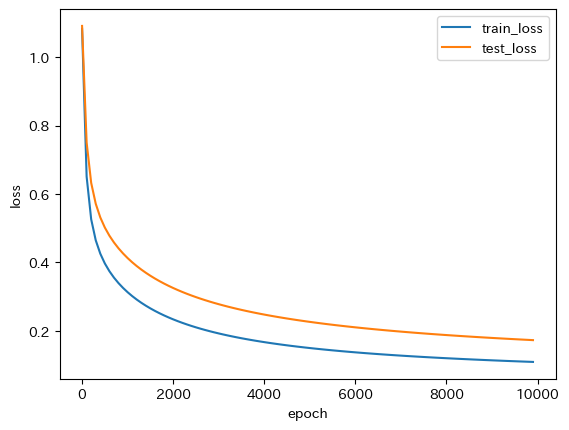

In [24]:
# 学習曲線(損失)の表示
plt.plot(history[:,0], history[:,1], label="train_loss")
plt.plot(history[:,0], history[:,2], label="test_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

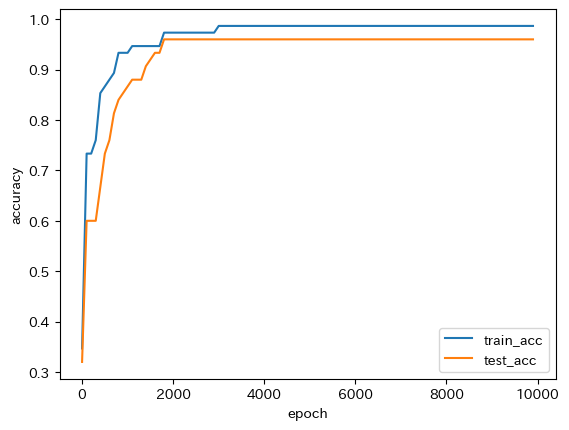

In [25]:
# 学習曲線(正解率)の表示
plt.plot(history[:,0], history[:,3], label="train_acc")
plt.plot(history[:,0], history[:,4], label="test_acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()